In [18]:
from warnings import filterwarnings
filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
from seaborn import diverging_palette
import mlflow.sklearn
from sklearn import (
    ensemble,
    model_selection,
    preprocessing,
    tree
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    auc,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    precision_score,
    average_precision_score,
    recall_score,
    f1_score,
    precision_recall_curve,
    cohen_kappa_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    cross_val_predict
)
from yellowbrick.classifier import (
    ConfusionMatrix,
    ROCAUC
)
from yellowbrick.model_selection import (
    LearningCurve 
)

from imblearn.over_sampling import (
    SMOTE, ADASYN
)

In [19]:
from mlflow.tracking import MlflowClient
mlflow.set_tracking_uri('http://127.0.0.1:5000/')

client = MlflowClient()

experiment_name = "Group Project"

if not client.get_experiment_by_name(experiment_name):
    experiment_id = client.create_experiment(experiment_name)
else:
    experiment_id = client.get_experiment_by_name(experiment_name).experiment_id

mlflow.set_experiment(experiment_name)

print("Experiment ID:", experiment_id)

Experiment ID: 954693324383087299


In [20]:
mlflow.start_run()

mlflow.log_param("test_size", 0.15)
mlflow.log_param("validation_size", 0.15)
mlflow.log_param("train_size", 0.7)
mlflow.log_param("random_state", 42)

exec(open("preprocess.py").read())

mlflow.log_artifact("preprocess.py")


In [21]:
exec(open("classification_score.py").read())
mlflow.log_artifact("classification_score.py")


Validation Result:

accuracy score: 0.8988



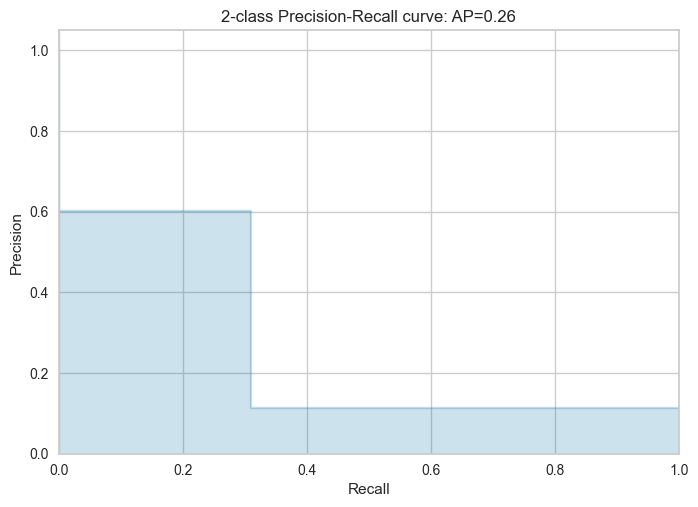

roc auc score: 0.6416803484408006



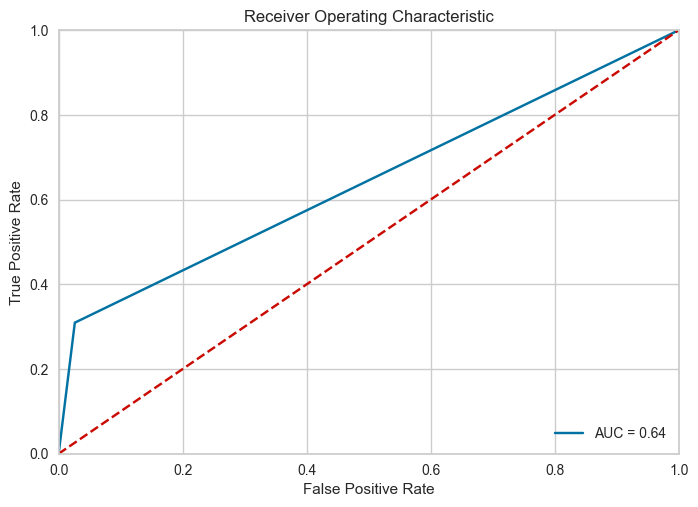

Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.97      0.94      5480
           1       0.60      0.31      0.41       698

    accuracy                           0.90      6178
   macro avg       0.76      0.64      0.68      6178
weighted avg       0.88      0.90      0.88      6178


Confusion Matrix: 
 [[5337  143]
 [ 482  216]]



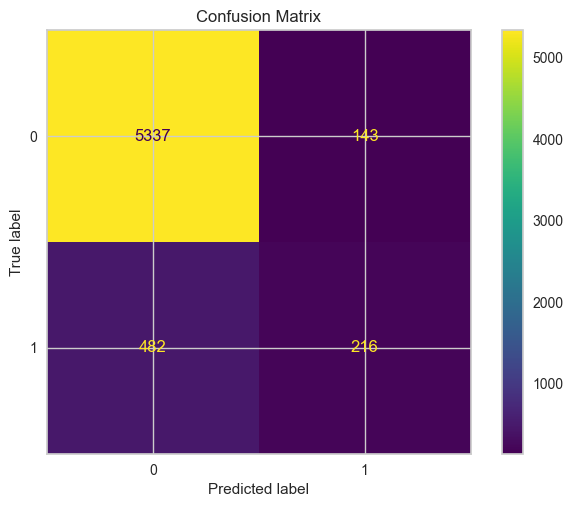

End of validation Result



Registered model 'xgb_classification' already exists. Creating a new version of this model...
2024/04/26 05:39:56 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: xgb_classification, version 1


Test Accuracy: 0.8922
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      5488
           1       0.53      0.30      0.38       691

    accuracy                           0.89      6179
   macro avg       0.72      0.63      0.66      6179
weighted avg       0.87      0.89      0.88      6179



Created version '1' of model 'xgb_classification'.


In [23]:
import xgboost as xgb
import pickle
colsample_bytree=0.8
learning_rate=0.2
max_depth=7
n_estimators=100
random_state=42
subsample=1.0
mlflow.log_param("colsample_bytree", colsample_bytree)
mlflow.log_param("learning_rate", learning_rate)
mlflow.log_param("max_depth", max_depth)
mlflow.log_param("n_estimators", n_estimators)
mlflow.log_param("subsample", subsample)
mlflow.log_param("random state", random_state)


clf_xgb = xgb.XGBClassifier(colsample_bytree=colsample_bytree, learning_rate=learning_rate, max_depth=max_depth,
                            n_estimators=n_estimators, random_state=random_state, subsample=subsample)
model = clf_xgb.fit(X_train_sm, y_train_sm)
clf_score(clf_xgb, X_train_sm, y_train_sm, X_val, y_val, train=False)

with open('xgb_classification.pkl', 'wb') as file:
    pickle.dump(model, file)
    
mlflow.xgboost.log_model(model, "xgb_classification")
run_id = mlflow.active_run().info.run_id
model_uri = f"runs:/{run_id}/xgb_classification"
model_details = mlflow.register_model(model_uri, "xgb_classification")
mlflow.log_artifact('xgb_classification.pkl', artifact_path='xgb_classification.pkl')
        
from sklearn.metrics import accuracy_score, classification_report

y_test_pred = clf_xgb.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')
mlflow.log_metric("test_accuracy", test_accuracy)


# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_test_pred))


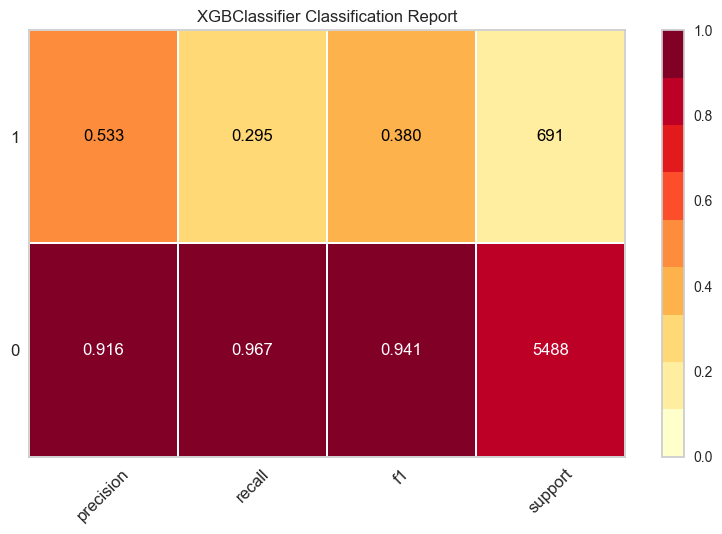

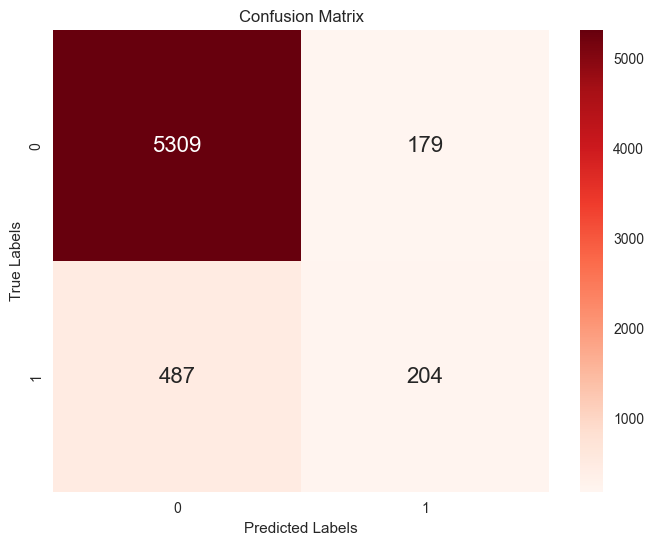

In [7]:
from yellowbrick.classifier import ClassificationReport

classes = ["0", "1"]

visualizer = ClassificationReport(
    clf_xgb, classes=classes, support=True, is_fitted=True
)

visualizer.fit(X_train_sm, y_train_sm)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
plt.savefig('XGClassifier Classification Report.png')
visualizer.show()                       # Finalize and show the figure


cm = confusion_matrix(y_test, y_test_pred)

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", annot_kws={"size": 16})
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.savefig('XGClassifier Confusion Matrix.png')
plt.show()

mlflow.log_artifact('XGClassifier Confusion Matrix.png', artifact_path='XGClassifier Confusion Matrix.png')
mlflow.log_artifact('XGClassifier Classification Report.png', artifact_path='XGClassifier Classification Report.png')



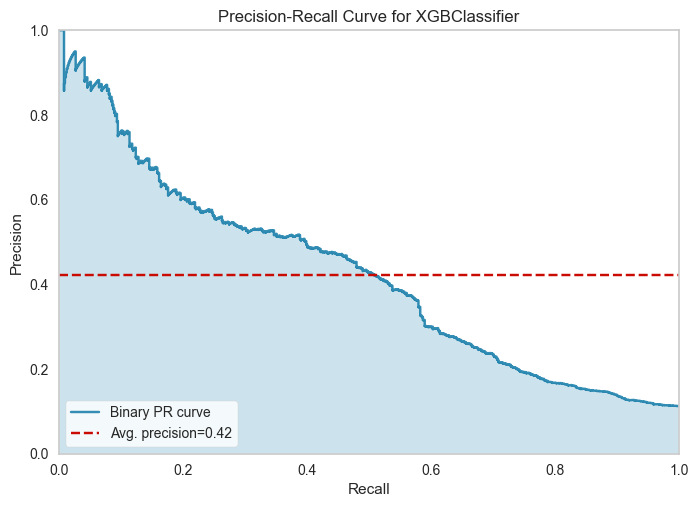

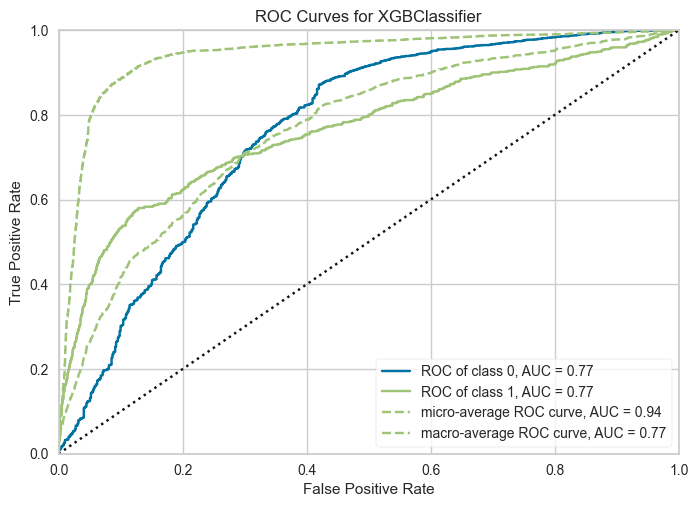

In [8]:
from yellowbrick.classifier import PrecisionRecallCurve
# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(clf_xgb, is_fitted=True)
viz.fit(X_train_sm, y_train_sm)
viz.score(X_test, y_test)
plt.savefig('XGClassifier Precision-Recall Curve.png')
viz.show()


visualizer = ROCAUC(
    clf_xgb, classes=classes, is_fitted=True
)

visualizer.fit(X_train_sm, y_train_sm)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
plt.savefig('XGClassifier ROC Curves.png')
visualizer.show()                       # Finalize and show the figure
mlflow.log_artifact('XGClassifier ROC Curves.png', artifact_path='XGClassifier ROC Curves.png')

mlflow.log_artifact('XGClassifier Precision-Recall Curve.png', artifact_path='XGClassifier Precision-Recall Curve.png')


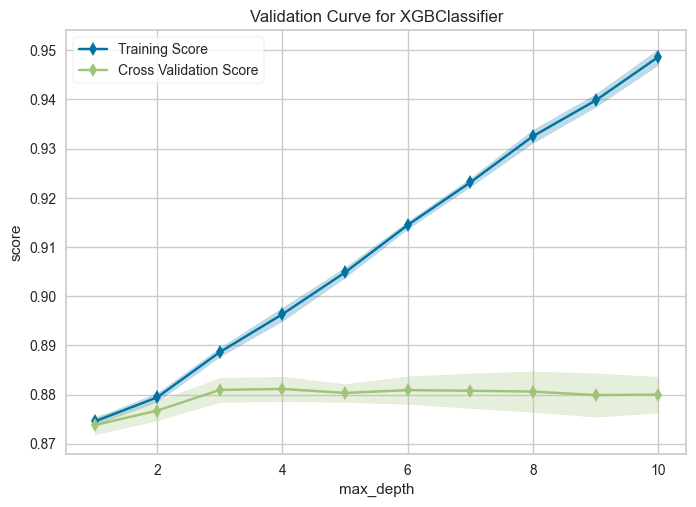

<Figure size 800x550 with 0 Axes>

In [9]:


from yellowbrick.model_selection import ValidationCurve

viz = ValidationCurve(
    xgb.XGBClassifier(colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, random_state=42, subsample=1.0), 
    param_name="max_depth",
    param_range=np.arange(1, 11), 
    cv=5, 
    scoring="f1_weighted",
    np_jobs=8
)

# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.poof()
plt.savefig('Validation Curve for XGBClassifier.png')
viz.show()                       # Finalize and show the figure
mlflow.log_artifact('Validation Curve for XGBClassifier.png', artifact_path='Validation Curve for XGBClassifier.png')


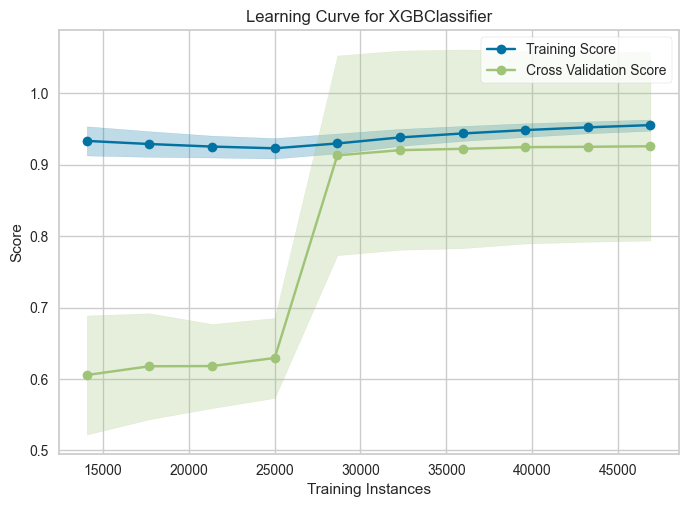

<Figure size 800x550 with 0 Axes>

In [10]:


from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import LearningCurve


# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=12)
sizes = np.linspace(0.3, 1.0, 10)

# Instantiate the classification model and visualizer

visualizer = LearningCurve(
    xgb.XGBClassifier(colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, random_state=42, subsample=1.0), 
    cv=cv, 
    scoring='f1_weighted', 
    train_sizes=sizes, 
    n_jobs=8
)

visualizer.fit(X_train_sm, y_train_sm)        # Fit the data to the visualizer
visualizer.poof()                       # Finalize and render the figure
plt.savefig('Learning Curve for XGBClassifier.png')
viz.show()                       # Finalize and show the figure
mlflow.log_artifact('Learning Curve for XGBClassifier.png', artifact_path='Learning Curve for XGBClassifier.png')

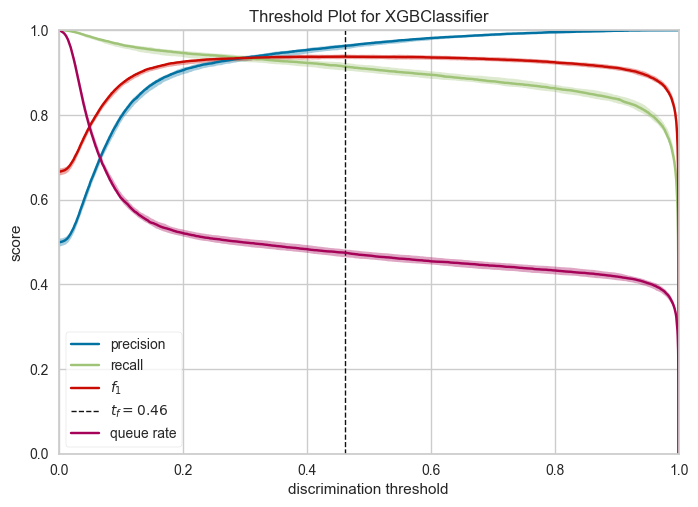

<Figure size 800x550 with 0 Axes>

In [13]:
from yellowbrick.classifier import DiscriminationThreshold

visualizer = DiscriminationThreshold(clf_xgb, is_fitted=True)

visualizer.fit(X_train_sm, y_train_sm)
visualizer.poof() 
plt.savefig('Threshold Plot for XGBClassifier.png')
viz.show()                       # Finalize and show the figure
mlflow.log_artifact('Threshold Plot for XGBClassifier.png', artifact_path='Threshold Plot for XGBClassifier.png')



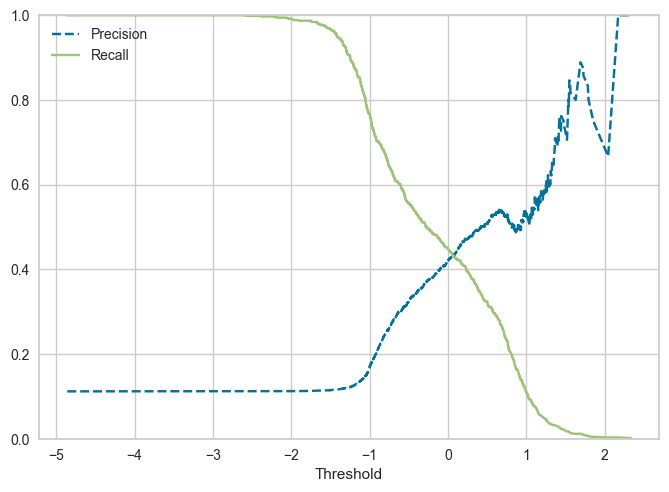

In [14]:

from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve

clf_svc = SVC(gamma='auto')
clf_svc.fit(X_train_sm, y_train_sm)

# call decision_function on classifier to get scores (probas_pred)
probas_pred = clf_svc.decision_function(X_test)
# compute precision-recall pairs for different probability thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, probas_pred)
# precision and recall vs. the decision threshold
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="upper left")
plt.ylim([0, 1])
plt.savefig('precision and recall vs. the decision threshold.png')
plt.show()
mlflow.log_artifact('precision and recall vs. the decision threshold.png', artifact_path='precision and recall vs. the decision threshold.png')




In [24]:
mlflow.end_run()